# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

  352256/11490434 [..............................] - ETA: 1s

 6127616/11490434 [==============>...............] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 13:34 - loss: 0.6925

  28/1875 [..............................] - ETA: 3s - loss: 0.5439   

  54/1875 [..............................] - ETA: 3s - loss: 0.4691

  83/1875 [>.............................] - ETA: 3s - loss: 0.4245

 110/1875 [>.............................] - ETA: 3s - loss: 0.3982

 139/1875 [=>............................] - ETA: 3s - loss: 0.3778

 166/1875 [=>............................] - ETA: 3s - loss: 0.3631

 192/1875 [==>...........................] - ETA: 3s - loss: 0.3515

 217/1875 [==>...........................] - ETA: 3s - loss: 0.3420

 245/1875 [==>...........................] - ETA: 3s - loss: 0.3326

 274/1875 [===>..........................] - ETA: 3s - loss: 0.3242

 301/1875 [===>..........................] - ETA: 2s - loss: 0.3171

 327/1875 [====>.........................] - ETA: 2s - loss: 0.3110

 358/1875 [====>.........................] - ETA: 2s - loss: 0.3043

 390/1875 [=====>........................] - ETA: 2s - loss: 0.2982

 413/1875 [=====>........................] - ETA: 2s - loss: 0.2941

 440/1875 [======>.......................] - ETA: 2s - loss: 0.2896

 467/1875 [======>.......................] - ETA: 2s - loss: 0.2855

 492/1875 [======>.......................] - ETA: 2s - loss: 0.2819

 517/1875 [=======>......................] - ETA: 2s - loss: 0.2785

 543/1875 [=======>......................] - ETA: 2s - loss: 0.2752

 568/1875 [========>.....................] - ETA: 2s - loss: 0.2721

 589/1875 [========>.....................] - ETA: 2s - loss: 0.2697

 615/1875 [========>.....................] - ETA: 2s - loss: 0.2669

 647/1875 [=========>....................] - ETA: 2s - loss: 0.2636

 677/1875 [=========>....................] - ETA: 2s - loss: 0.2606

 706/1875 [==========>...................] - ETA: 2s - loss: 0.2579

 734/1875 [==========>...................] - ETA: 2s - loss: 0.2554

 760/1875 [===========>..................] - ETA: 2s - loss: 0.2532

 787/1875 [===========>..................] - ETA: 2s - loss: 0.2510

 816/1875 [============>.................] - ETA: 1s - loss: 0.2488

 844/1875 [============>.................] - ETA: 1s - loss: 0.2467

 872/1875 [============>.................] - ETA: 1s - loss: 0.2447

 902/1875 [=============>................] - ETA: 1s - loss: 0.2426

 933/1875 [=============>................] - ETA: 1s - loss: 0.2405

 966/1875 [==============>...............] - ETA: 1s - loss: 0.2384

 999/1875 [==============>...............] - ETA: 1s - loss: 0.2364

1032/1875 [===============>..............] - ETA: 1s - loss: 0.2345

1064/1875 [================>.............] - ETA: 1s - loss: 0.2327

1096/1875 [================>.............] - ETA: 1s - loss: 0.2309

1129/1875 [=================>............] - ETA: 1s - loss: 0.2292

1158/1875 [=================>............] - ETA: 1s - loss: 0.2277

1187/1875 [=================>............] - ETA: 1s - loss: 0.2263

1209/1875 [==================>...........] - ETA: 1s - loss: 0.2252

1232/1875 [==================>...........] - ETA: 1s - loss: 0.2242

1256/1875 [===================>..........] - ETA: 1s - loss: 0.2231

1282/1875 [===================>..........] - ETA: 1s - loss: 0.2219

1316/1875 [====================>.........] - ETA: 1s - loss: 0.2204

1349/1875 [====================>.........] - ETA: 0s - loss: 0.2190

1382/1875 [=====================>........] - ETA: 0s - loss: 0.2177

1414/1875 [=====================>........] - ETA: 0s - loss: 0.2164

1445/1875 [======================>.......] - ETA: 0s - loss: 0.2152

1471/1875 [======================>.......] - ETA: 0s - loss: 0.2142

1498/1875 [======================>.......] - ETA: 0s - loss: 0.2132

1524/1875 [=======================>......] - ETA: 0s - loss: 0.2123

1549/1875 [=======================>......] - ETA: 0s - loss: 0.2114

1575/1875 [========================>.....] - ETA: 0s - loss: 0.2105

1601/1875 [========================>.....] - ETA: 0s - loss: 0.2096

1625/1875 [=========================>....] - ETA: 0s - loss: 0.2088

1651/1875 [=========================>....] - ETA: 0s - loss: 0.2079

1676/1875 [=========================>....] - ETA: 0s - loss: 0.2071

1701/1875 [==========================>...] - ETA: 0s - loss: 0.2063

1727/1875 [==========================>...] - ETA: 0s - loss: 0.2055

1753/1875 [===========================>..] - ETA: 0s - loss: 0.2047

1779/1875 [===========================>..] - ETA: 0s - loss: 0.2040

1805/1875 [===========================>..] - ETA: 0s - loss: 0.2032

1832/1875 [============================>.] - ETA: 0s - loss: 0.2024

1859/1875 [============================>.] - ETA: 0s - loss: 0.2017

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2012


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1085

  27/1875 [..............................] - ETA: 3s - loss: 0.1081

  54/1875 [..............................] - ETA: 3s - loss: 0.1087

  80/1875 [>.............................] - ETA: 3s - loss: 0.1088

 102/1875 [>.............................] - ETA: 3s - loss: 0.1089

 127/1875 [=>............................] - ETA: 3s - loss: 0.1089

 149/1875 [=>............................] - ETA: 3s - loss: 0.1090

 172/1875 [=>............................] - ETA: 3s - loss: 0.1090

 195/1875 [==>...........................] - ETA: 3s - loss: 0.1090

 222/1875 [==>...........................] - ETA: 3s - loss: 0.1090

 250/1875 [===>..........................] - ETA: 3s - loss: 0.1090

 277/1875 [===>..........................] - ETA: 3s - loss: 0.1089

 305/1875 [===>..........................] - ETA: 3s - loss: 0.1089

 331/1875 [====>.........................] - ETA: 3s - loss: 0.1089

 359/1875 [====>.........................] - ETA: 3s - loss: 0.1088

 386/1875 [=====>........................] - ETA: 2s - loss: 0.1088

 413/1875 [=====>........................] - ETA: 2s - loss: 0.1088

 439/1875 [======>.......................] - ETA: 2s - loss: 0.1087

 466/1875 [======>.......................] - ETA: 2s - loss: 0.1087

 494/1875 [======>.......................] - ETA: 2s - loss: 0.1086

 521/1875 [=======>......................] - ETA: 2s - loss: 0.1086

 549/1875 [=======>......................] - ETA: 2s - loss: 0.1085

 576/1875 [========>.....................] - ETA: 2s - loss: 0.1085

 603/1875 [========>.....................] - ETA: 2s - loss: 0.1084

 632/1875 [=========>....................] - ETA: 2s - loss: 0.1084

 656/1875 [=========>....................] - ETA: 2s - loss: 0.1084

 676/1875 [=========>....................] - ETA: 2s - loss: 0.1083

 703/1875 [==========>...................] - ETA: 2s - loss: 0.1083

 725/1875 [==========>...................] - ETA: 2s - loss: 0.1082

 745/1875 [==========>...................] - ETA: 2s - loss: 0.1082

 770/1875 [===========>..................] - ETA: 2s - loss: 0.1081

 797/1875 [===========>..................] - ETA: 2s - loss: 0.1081

 823/1875 [============>.................] - ETA: 2s - loss: 0.1081

 846/1875 [============>.................] - ETA: 2s - loss: 0.1080

 868/1875 [============>.................] - ETA: 2s - loss: 0.1080

 892/1875 [=============>................] - ETA: 1s - loss: 0.1079

 917/1875 [=============>................] - ETA: 1s - loss: 0.1079

 937/1875 [=============>................] - ETA: 1s - loss: 0.1079

 962/1875 [==============>...............] - ETA: 1s - loss: 0.1078

 988/1875 [==============>...............] - ETA: 1s - loss: 0.1078

1013/1875 [===============>..............] - ETA: 1s - loss: 0.1077

1038/1875 [===============>..............] - ETA: 1s - loss: 0.1077

1063/1875 [================>.............] - ETA: 1s - loss: 0.1076

1087/1875 [================>.............] - ETA: 1s - loss: 0.1076

1111/1875 [================>.............] - ETA: 1s - loss: 0.1076

1137/1875 [=================>............] - ETA: 1s - loss: 0.1075

1163/1875 [=================>............] - ETA: 1s - loss: 0.1075

1188/1875 [==================>...........] - ETA: 1s - loss: 0.1074

1213/1875 [==================>...........] - ETA: 1s - loss: 0.1074

1238/1875 [==================>...........] - ETA: 1s - loss: 0.1074

1263/1875 [===================>..........] - ETA: 1s - loss: 0.1073

1287/1875 [===================>..........] - ETA: 1s - loss: 0.1073

1312/1875 [===================>..........] - ETA: 1s - loss: 0.1072

1337/1875 [====================>.........] - ETA: 1s - loss: 0.1072

1363/1875 [====================>.........] - ETA: 1s - loss: 0.1072

1389/1875 [=====================>........] - ETA: 0s - loss: 0.1071

1416/1875 [=====================>........] - ETA: 0s - loss: 0.1071

1442/1875 [======================>.......] - ETA: 0s - loss: 0.1070

1468/1875 [======================>.......] - ETA: 0s - loss: 0.1070

1493/1875 [======================>.......] - ETA: 0s - loss: 0.1069

1519/1875 [=======================>......] - ETA: 0s - loss: 0.1069

1546/1875 [=======================>......] - ETA: 0s - loss: 0.1069

1572/1875 [========================>.....] - ETA: 0s - loss: 0.1068

1598/1875 [========================>.....] - ETA: 0s - loss: 0.1068

1624/1875 [========================>.....] - ETA: 0s - loss: 0.1067

1648/1875 [=========================>....] - ETA: 0s - loss: 0.1067

1673/1875 [=========================>....] - ETA: 0s - loss: 0.1067

1699/1875 [==========================>...] - ETA: 0s - loss: 0.1066

1723/1875 [==========================>...] - ETA: 0s - loss: 0.1066

1750/1875 [===========================>..] - ETA: 0s - loss: 0.1065

1775/1875 [===========================>..] - ETA: 0s - loss: 0.1065

1800/1875 [===========================>..] - ETA: 0s - loss: 0.1065

1822/1875 [============================>.] - ETA: 0s - loss: 0.1064

1846/1875 [============================>.] - ETA: 0s - loss: 0.1064

1871/1875 [============================>.] - ETA: 0s - loss: 0.1063

1875/1875 [==============================] - 4s 2ms/step - loss: 0.1063


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1035

  24/1875 [..............................] - ETA: 4s - loss: 0.0986

  44/1875 [..............................] - ETA: 4s - loss: 0.0991

  68/1875 [>.............................] - ETA: 4s - loss: 0.0989

  93/1875 [>.............................] - ETA: 3s - loss: 0.0989

 120/1875 [>.............................] - ETA: 3s - loss: 0.0988

 147/1875 [=>............................] - ETA: 3s - loss: 0.0988

 174/1875 [=>............................] - ETA: 3s - loss: 0.0988

 200/1875 [==>...........................] - ETA: 3s - loss: 0.0988

 227/1875 [==>...........................] - ETA: 3s - loss: 0.0988

 252/1875 [===>..........................] - ETA: 3s - loss: 0.0988

 279/1875 [===>..........................] - ETA: 3s - loss: 0.0988

 306/1875 [===>..........................] - ETA: 3s - loss: 0.0988

 333/1875 [====>.........................] - ETA: 3s - loss: 0.0987

 359/1875 [====>.........................] - ETA: 3s - loss: 0.0987

 385/1875 [=====>........................] - ETA: 2s - loss: 0.0987

 410/1875 [=====>........................] - ETA: 2s - loss: 0.0987

 436/1875 [=====>........................] - ETA: 2s - loss: 0.0987

 463/1875 [======>.......................] - ETA: 2s - loss: 0.0987

 489/1875 [======>.......................] - ETA: 2s - loss: 0.0987

 516/1875 [=======>......................] - ETA: 2s - loss: 0.0987

 542/1875 [=======>......................] - ETA: 2s - loss: 0.0987

 569/1875 [========>.....................] - ETA: 2s - loss: 0.0986

 596/1875 [========>.....................] - ETA: 2s - loss: 0.0986

 622/1875 [========>.....................] - ETA: 2s - loss: 0.0986

 649/1875 [=========>....................] - ETA: 2s - loss: 0.0986

 675/1875 [=========>....................] - ETA: 2s - loss: 0.0986

 702/1875 [==========>...................] - ETA: 2s - loss: 0.0986

 728/1875 [==========>...................] - ETA: 2s - loss: 0.0986

 755/1875 [===========>..................] - ETA: 2s - loss: 0.0986

 781/1875 [===========>..................] - ETA: 2s - loss: 0.0986

 806/1875 [===========>..................] - ETA: 2s - loss: 0.0986

 832/1875 [============>.................] - ETA: 2s - loss: 0.0985

 859/1875 [============>.................] - ETA: 1s - loss: 0.0985

 883/1875 [=============>................] - ETA: 1s - loss: 0.0985

 906/1875 [=============>................] - ETA: 1s - loss: 0.0985

 932/1875 [=============>................] - ETA: 1s - loss: 0.0985

 957/1875 [==============>...............] - ETA: 1s - loss: 0.0985

 982/1875 [==============>...............] - ETA: 1s - loss: 0.0985

1008/1875 [===============>..............] - ETA: 1s - loss: 0.0984

1034/1875 [===============>..............] - ETA: 1s - loss: 0.0984

1060/1875 [===============>..............] - ETA: 1s - loss: 0.0984

1083/1875 [================>.............] - ETA: 1s - loss: 0.0984

1112/1875 [================>.............] - ETA: 1s - loss: 0.0984

1136/1875 [=================>............] - ETA: 1s - loss: 0.0984

1157/1875 [=================>............] - ETA: 1s - loss: 0.0984

1177/1875 [=================>............] - ETA: 1s - loss: 0.0984

1200/1875 [==================>...........] - ETA: 1s - loss: 0.0984

1225/1875 [==================>...........] - ETA: 1s - loss: 0.0984

1248/1875 [==================>...........] - ETA: 1s - loss: 0.0983

1271/1875 [===================>..........] - ETA: 1s - loss: 0.0983

1297/1875 [===================>..........] - ETA: 1s - loss: 0.0983

1319/1875 [====================>.........] - ETA: 1s - loss: 0.0983

1340/1875 [====================>.........] - ETA: 1s - loss: 0.0983

1365/1875 [====================>.........] - ETA: 1s - loss: 0.0983

1388/1875 [=====================>........] - ETA: 0s - loss: 0.0983

1414/1875 [=====================>........] - ETA: 0s - loss: 0.0983

1439/1875 [======================>.......] - ETA: 0s - loss: 0.0983

1465/1875 [======================>.......] - ETA: 0s - loss: 0.0983

1491/1875 [======================>.......] - ETA: 0s - loss: 0.0982

1516/1875 [=======================>......] - ETA: 0s - loss: 0.0982

1541/1875 [=======================>......] - ETA: 0s - loss: 0.0982

1565/1875 [========================>.....] - ETA: 0s - loss: 0.0982

1590/1875 [========================>.....] - ETA: 0s - loss: 0.0982

1615/1875 [========================>.....] - ETA: 0s - loss: 0.0982

1638/1875 [=========================>....] - ETA: 0s - loss: 0.0982

1665/1875 [=========================>....] - ETA: 0s - loss: 0.0982

1690/1875 [==========================>...] - ETA: 0s - loss: 0.0982

1714/1875 [==========================>...] - ETA: 0s - loss: 0.0982

1739/1875 [==========================>...] - ETA: 0s - loss: 0.0982

1765/1875 [===========================>..] - ETA: 0s - loss: 0.0981

1791/1875 [===========================>..] - ETA: 0s - loss: 0.0981

1817/1875 [============================>.] - ETA: 0s - loss: 0.0981

1843/1875 [============================>.] - ETA: 0s - loss: 0.0981

1872/1875 [============================>.] - ETA: 0s - loss: 0.0981

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0981


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1020

  27/1875 [..............................] - ETA: 3s - loss: 0.0978

  50/1875 [..............................] - ETA: 3s - loss: 0.0975

  71/1875 [>.............................] - ETA: 3s - loss: 0.0974

  96/1875 [>.............................] - ETA: 3s - loss: 0.0973

 122/1875 [>.............................] - ETA: 3s - loss: 0.0973

 149/1875 [=>............................] - ETA: 3s - loss: 0.0972

 175/1875 [=>............................] - ETA: 3s - loss: 0.0971

 199/1875 [==>...........................] - ETA: 3s - loss: 0.0971

 223/1875 [==>...........................] - ETA: 3s - loss: 0.0971

 245/1875 [==>...........................] - ETA: 3s - loss: 0.0971

 266/1875 [===>..........................] - ETA: 3s - loss: 0.0971

 286/1875 [===>..........................] - ETA: 3s - loss: 0.0971

 310/1875 [===>..........................] - ETA: 3s - loss: 0.0971

 335/1875 [====>.........................] - ETA: 3s - loss: 0.0971

 362/1875 [====>.........................] - ETA: 3s - loss: 0.0971

 389/1875 [=====>........................] - ETA: 3s - loss: 0.0971

 415/1875 [=====>........................] - ETA: 3s - loss: 0.0970

 441/1875 [======>.......................] - ETA: 2s - loss: 0.0970

 467/1875 [======>.......................] - ETA: 2s - loss: 0.0970

 494/1875 [======>.......................] - ETA: 2s - loss: 0.0970

 522/1875 [=======>......................] - ETA: 2s - loss: 0.0970

 539/1875 [=======>......................] - ETA: 2s - loss: 0.0970

 561/1875 [=======>......................] - ETA: 2s - loss: 0.0969

 590/1875 [========>.....................] - ETA: 2s - loss: 0.0969

 616/1875 [========>.....................] - ETA: 2s - loss: 0.0969

 641/1875 [=========>....................] - ETA: 2s - loss: 0.0969

 663/1875 [=========>....................] - ETA: 2s - loss: 0.0969

 684/1875 [=========>....................] - ETA: 2s - loss: 0.0969

 709/1875 [==========>...................] - ETA: 2s - loss: 0.0969

 733/1875 [==========>...................] - ETA: 2s - loss: 0.0968

 760/1875 [===========>..................] - ETA: 2s - loss: 0.0968

 786/1875 [===========>..................] - ETA: 2s - loss: 0.0968

 810/1875 [===========>..................] - ETA: 2s - loss: 0.0968

 833/1875 [============>.................] - ETA: 2s - loss: 0.0968

 853/1875 [============>.................] - ETA: 2s - loss: 0.0968

 876/1875 [=============>................] - ETA: 2s - loss: 0.0968

 900/1875 [=============>................] - ETA: 2s - loss: 0.0968

 924/1875 [=============>................] - ETA: 2s - loss: 0.0967

 947/1875 [==============>...............] - ETA: 1s - loss: 0.0967

 969/1875 [==============>...............] - ETA: 1s - loss: 0.0967

 992/1875 [==============>...............] - ETA: 1s - loss: 0.0967

1012/1875 [===============>..............] - ETA: 1s - loss: 0.0967

1038/1875 [===============>..............] - ETA: 1s - loss: 0.0967

1064/1875 [================>.............] - ETA: 1s - loss: 0.0967

1089/1875 [================>.............] - ETA: 1s - loss: 0.0967

1115/1875 [================>.............] - ETA: 1s - loss: 0.0967

1136/1875 [=================>............] - ETA: 1s - loss: 0.0967

1163/1875 [=================>............] - ETA: 1s - loss: 0.0967

1186/1875 [=================>............] - ETA: 1s - loss: 0.0967

1213/1875 [==================>...........] - ETA: 1s - loss: 0.0966

1238/1875 [==================>...........] - ETA: 1s - loss: 0.0966

1264/1875 [===================>..........] - ETA: 1s - loss: 0.0966

1291/1875 [===================>..........] - ETA: 1s - loss: 0.0966

1316/1875 [====================>.........] - ETA: 1s - loss: 0.0966

1340/1875 [====================>.........] - ETA: 1s - loss: 0.0966

1365/1875 [====================>.........] - ETA: 1s - loss: 0.0966

1391/1875 [=====================>........] - ETA: 1s - loss: 0.0966

1417/1875 [=====================>........] - ETA: 0s - loss: 0.0966

1441/1875 [======================>.......] - ETA: 0s - loss: 0.0966

1471/1875 [======================>.......] - ETA: 0s - loss: 0.0966

1495/1875 [======================>.......] - ETA: 0s - loss: 0.0966

1518/1875 [=======================>......] - ETA: 0s - loss: 0.0966

1545/1875 [=======================>......] - ETA: 0s - loss: 0.0965

1569/1875 [========================>.....] - ETA: 0s - loss: 0.0965

1589/1875 [========================>.....] - ETA: 0s - loss: 0.0965

1608/1875 [========================>.....] - ETA: 0s - loss: 0.0965

1632/1875 [=========================>....] - ETA: 0s - loss: 0.0965

1655/1875 [=========================>....] - ETA: 0s - loss: 0.0965

1679/1875 [=========================>....] - ETA: 0s - loss: 0.0965

1706/1875 [==========================>...] - ETA: 0s - loss: 0.0965

1730/1875 [==========================>...] - ETA: 0s - loss: 0.0965

1755/1875 [===========================>..] - ETA: 0s - loss: 0.0965

1774/1875 [===========================>..] - ETA: 0s - loss: 0.0965

1798/1875 [===========================>..] - ETA: 0s - loss: 0.0965

1820/1875 [============================>.] - ETA: 0s - loss: 0.0965

1841/1875 [============================>.] - ETA: 0s - loss: 0.0965

1863/1875 [============================>.] - ETA: 0s - loss: 0.0965

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0965


Epoch 5/5
   1/1875 [..............................] - ETA: 13s - loss: 0.0951

  28/1875 [..............................] - ETA: 3s - loss: 0.0941 

  54/1875 [..............................] - ETA: 3s - loss: 0.0942

  82/1875 [>.............................] - ETA: 3s - loss: 0.0943

 106/1875 [>.............................] - ETA: 3s - loss: 0.0944

 132/1875 [=>............................] - ETA: 3s - loss: 0.0945

 157/1875 [=>............................] - ETA: 3s - loss: 0.0946

 184/1875 [=>............................] - ETA: 3s - loss: 0.0947

 211/1875 [==>...........................] - ETA: 3s - loss: 0.0947

 237/1875 [==>...........................] - ETA: 3s - loss: 0.0948

 263/1875 [===>..........................] - ETA: 3s - loss: 0.0948

 290/1875 [===>..........................] - ETA: 3s - loss: 0.0948

 316/1875 [====>.........................] - ETA: 3s - loss: 0.0949

 341/1875 [====>.........................] - ETA: 2s - loss: 0.0949

 369/1875 [====>.........................] - ETA: 2s - loss: 0.0949

 396/1875 [=====>........................] - ETA: 2s - loss: 0.0949

 422/1875 [=====>........................] - ETA: 2s - loss: 0.0949

 449/1875 [======>.......................] - ETA: 2s - loss: 0.0949

 475/1875 [======>.......................] - ETA: 2s - loss: 0.0950

 501/1875 [=======>......................] - ETA: 2s - loss: 0.0950

 526/1875 [=======>......................] - ETA: 2s - loss: 0.0950

 553/1875 [=======>......................] - ETA: 2s - loss: 0.0950

 580/1875 [========>.....................] - ETA: 2s - loss: 0.0950

 607/1875 [========>.....................] - ETA: 2s - loss: 0.0950

 634/1875 [=========>....................] - ETA: 2s - loss: 0.0950

 661/1875 [=========>....................] - ETA: 2s - loss: 0.0950

 687/1875 [=========>....................] - ETA: 2s - loss: 0.0951

 713/1875 [==========>...................] - ETA: 2s - loss: 0.0951

 739/1875 [==========>...................] - ETA: 2s - loss: 0.0951

 765/1875 [===========>..................] - ETA: 2s - loss: 0.0951

 792/1875 [===========>..................] - ETA: 2s - loss: 0.0951

 819/1875 [============>.................] - ETA: 2s - loss: 0.0951

 846/1875 [============>.................] - ETA: 1s - loss: 0.0951

 872/1875 [============>.................] - ETA: 1s - loss: 0.0951

 897/1875 [=============>................] - ETA: 1s - loss: 0.0951

 926/1875 [=============>................] - ETA: 1s - loss: 0.0951

 946/1875 [==============>...............] - ETA: 1s - loss: 0.0951

 970/1875 [==============>...............] - ETA: 1s - loss: 0.0951

 994/1875 [==============>...............] - ETA: 1s - loss: 0.0952

1018/1875 [===============>..............] - ETA: 1s - loss: 0.0952

1041/1875 [===============>..............] - ETA: 1s - loss: 0.0952

1067/1875 [================>.............] - ETA: 1s - loss: 0.0952

1092/1875 [================>.............] - ETA: 1s - loss: 0.0952

1115/1875 [================>.............] - ETA: 1s - loss: 0.0952

1141/1875 [=================>............] - ETA: 1s - loss: 0.0952

1167/1875 [=================>............] - ETA: 1s - loss: 0.0952

1192/1875 [==================>...........] - ETA: 1s - loss: 0.0952

1217/1875 [==================>...........] - ETA: 1s - loss: 0.0952

1239/1875 [==================>...........] - ETA: 1s - loss: 0.0952

1262/1875 [===================>..........] - ETA: 1s - loss: 0.0952

1282/1875 [===================>..........] - ETA: 1s - loss: 0.0952

1306/1875 [===================>..........] - ETA: 1s - loss: 0.0952

1331/1875 [====================>.........] - ETA: 1s - loss: 0.0952

1357/1875 [====================>.........] - ETA: 1s - loss: 0.0952

1380/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1406/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1431/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1452/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1474/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1495/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1520/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1546/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1570/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1596/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1623/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1649/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1674/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1698/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1722/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1748/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1771/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1792/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1813/1875 [============================>.] - ETA: 0s - loss: 0.0952

1840/1875 [============================>.] - ETA: 0s - loss: 0.0952

1862/1875 [============================>.] - ETA: 0s - loss: 0.0952

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0952


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

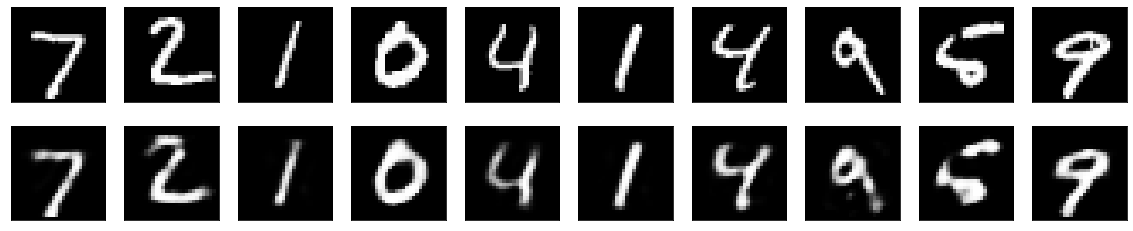

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
